In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import learning_curve
from sklearn.model_selection  import GridSearchCV
import scipy.stats as stats
import statsmodels.api as sm
import pylab
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

In [84]:
df = pd.read_csv('creditcard.csv')

# Before Quantile Transform

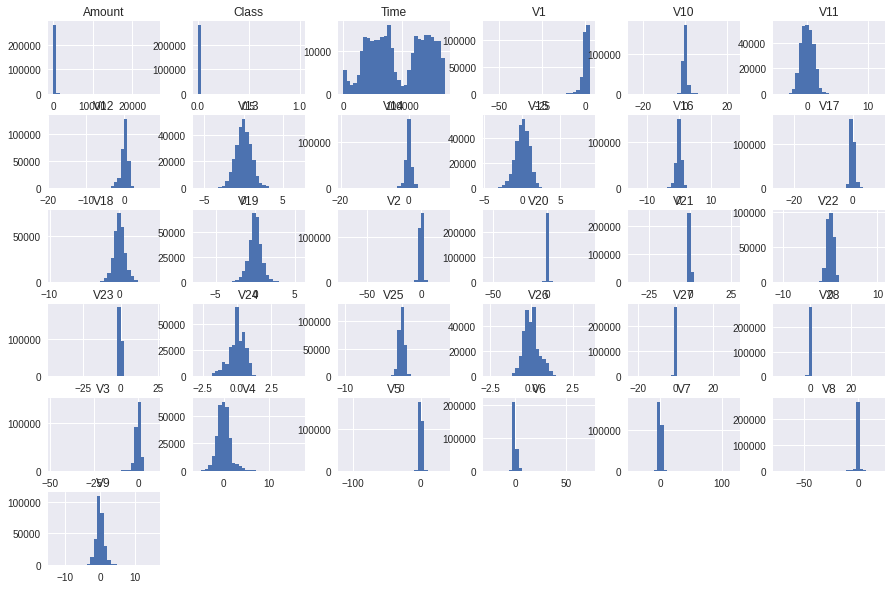

In [39]:
plt.style.use('seaborn')
df.hist(bins=30,figsize=(15,10))
plt.show()

# After Quantile transform

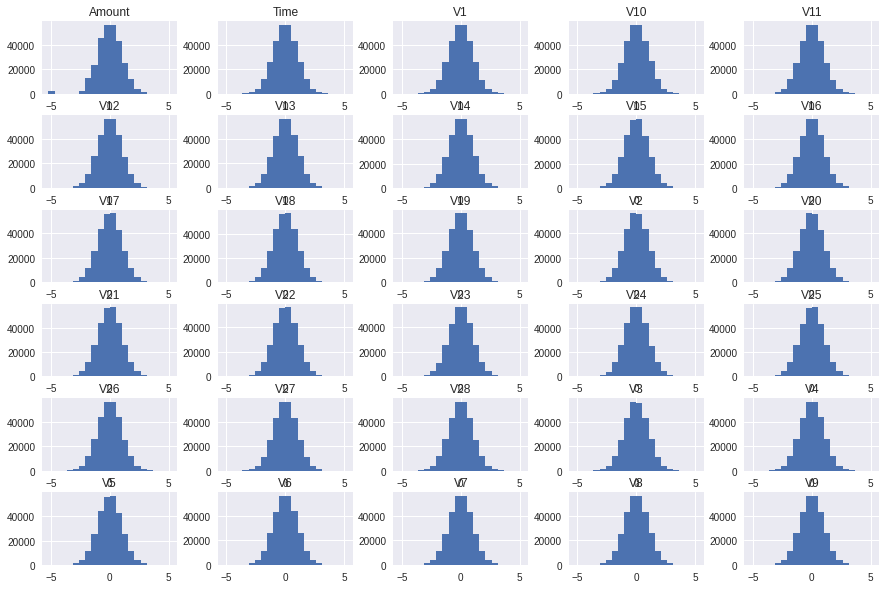

In [110]:
plt.style.use('seaborn')

df_quantile = pd.DataFrame()

for column in df.columns[:-1]:
    qt = QuantileTransformer(output_distribution='normal', copy=True, random_state=0)
    df_quantile[column] = qt.fit_transform( np.array(df[column]).reshape(-1,1)).flatten()

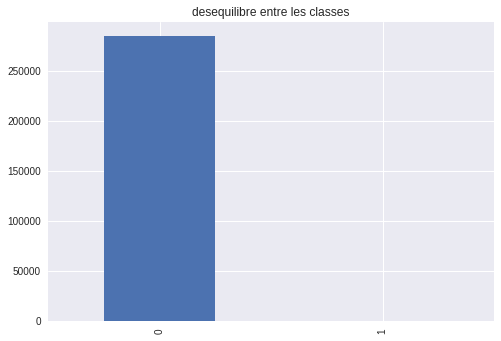

In [56]:
# visualisons le desequilibre entre les classes
class_count = df.Class.value_counts()
class_count.plot(kind='bar',title='desequilibre entre les classes')

In [6]:
# proportions des classes 0 (cas de non-fraudes) et 1 ( cas de fraudes) dans le jeu de donnees
taille = len(df)
print('Proportion de cas non-fraudes: ', 100*class_count[0]/taille)
print('Proportion de cas fraudes: ', 100*class_count[1]/taille)

Proportion de cas non-fraudes:  99.827251436938
Proportion de cas fraudes:  0.1727485630620034


IndexError: index 5 is out of bounds for axis 0 with size 5

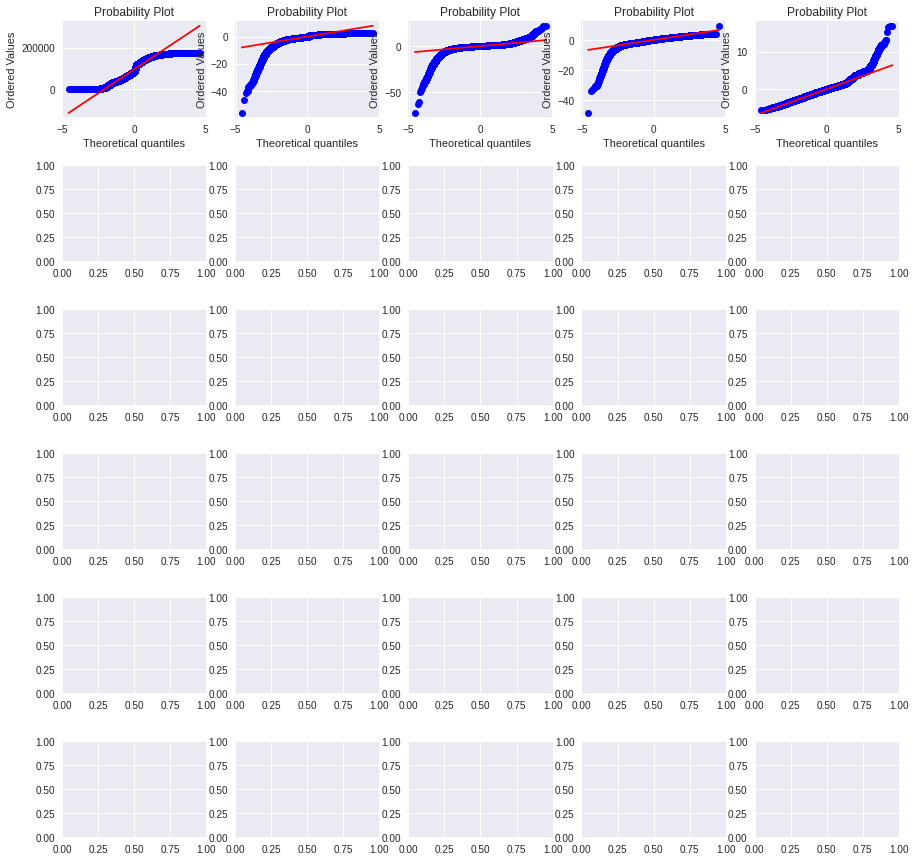

In [22]:
plt.style.use('seaborn')

NB_LIGNES = 6
NB_COLONNES = 5

f, axes = plt.subplots(NB_LIGNES,NB_COLONNES,figsize=(15,15))
f.subplots_adjust(hspace=0.5)

for axe in axes:
    j = 0
    for column in df.columns:
        # representer
        stats.probplot(df[column], dist="norm", plot=axe[j % NB_COLONNES])
        j += 1
        

On  remarque que le jeu de données est très déséquilibré : il y a moins  de 1% des cas de fraudes .

In [59]:
NB_LIGNES = 6
NB_COLONNES = 5

def visualiser_attributs(df):
    f, axes = plt.subplots(NB_LIGNES,NB_COLONNES,figsize=(15,15))
    f.subplots_adjust(hspace=0.5)
    SUBSET_0 = df[df['Class'] == 0]
    SUBSET_1 = df[df['Class'] == 1]

    j = 0
    for axe in axes:
        for i in range(NB_COLONNES):
            for class_ in [0,1]:
                # subset de la classe 
                subset =  SUBSET_0 if class_ == 0 else SUBSET_1
                # representer
                sns.distplot(subset[subset.columns[j]], hist = True, kde = True,
                         kde_kws = {'shade':True,'linewidth': 2},
                         label = 'Classe ' + str(class_),ax=axe[i])
            j += 1

# Visualisation des attributs  Sans  SMOTE

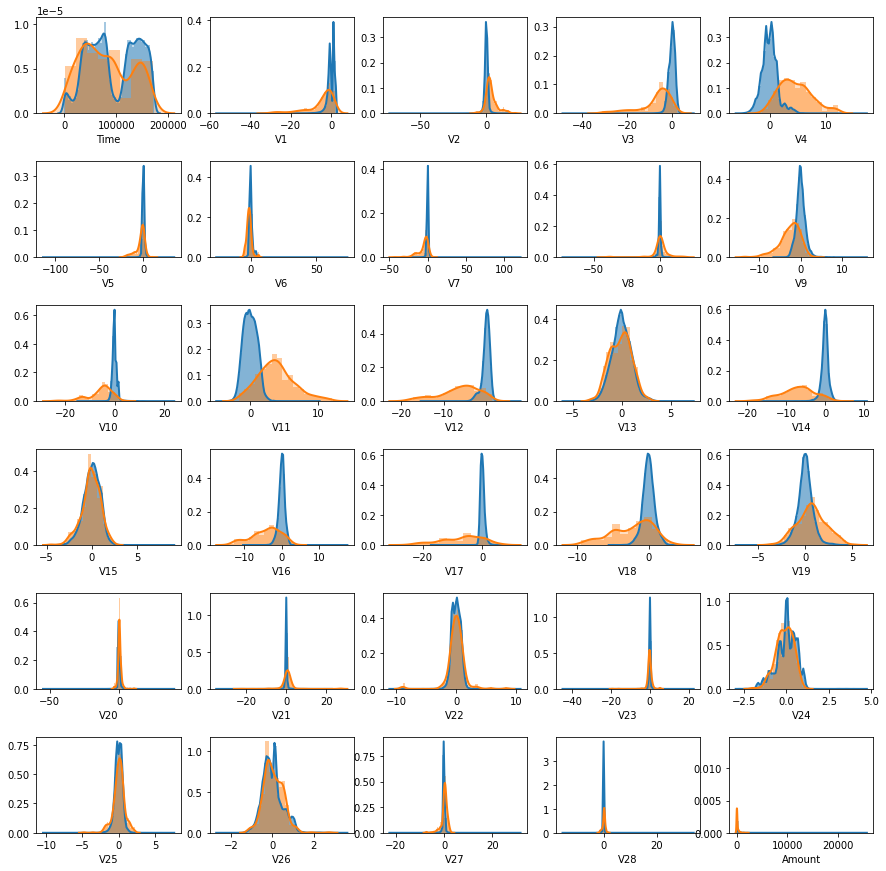

In [60]:
visualiser_attributs(df)

On remarque que les distributions se recouvrent dans tous les cas. On note aussi que la variance des attributs dans les cas des non-fraudes est très inferieure (courbe plus resseree) à celle des cas de fraudes (sauf V13 et V15). La distribution de l'attribut Time pour les deux classes est bimodale (si l'on prend en compte cette attribut dans le modèle, il faudra au prealable la mapper à une distribution gaussienne. L'attribut Amount varie très peu pour les deux classes. Comme il s'agit des resultats d'une ACP, la variance decroit de la première à la dernière composante.

# Visualisation des attributs  avec SMOTE


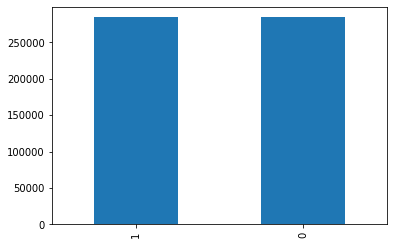

In [3]:
# sur-echantillonnage
df_sm, y_sm = SMOTE().fit_sample(df.loc[:,'Time':'Amount'],df.Class)

# ajouter la cible
df_sm['Class']  = y_sm.copy()

# verifions l'equilibre des classes
pd.Series(y_sm).value_counts().plot.bar()

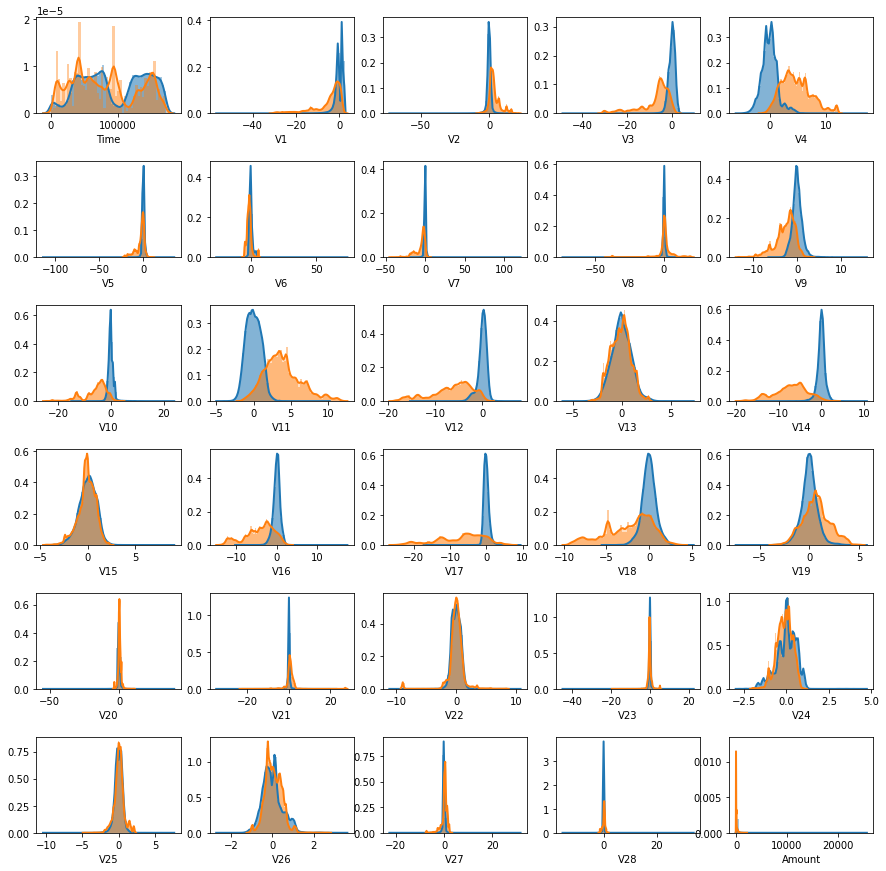

In [62]:
visualiser_attributs(df_sm)

SMOTE conserve assez bien la distribution des donnees

In [7]:
# extraction des donnees 
X = StandardScaler().fit_transform(df.loc[:,'Time':'Amount'])
# extraction de la classe 
y = df.Class

# Features Selection

In [7]:
# sparation du jeu de donnees enjeu d'entrainement et de test
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state=0,stratify=np.array(y))

# Modelèle

In [64]:
model1 = make_pipeline(StandardScaler(),LogisticRegression())

# Evaluation

In [5]:
def afficher_resultats(y_pred, y_true):
    
    print('Matrice de confusion')
    print(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    print(' \n')
    print('Resume de la classification')
    print(classification_report(y_true, y_pred)) 

def evaluation2(model, X_train, y_train):
    
    model.fit(X_train,y_train)
    
    y_pred_1 = model.predict(X_train)
    print('**** RESULTATS SUR LE JEU D\'ENTRAINEMENT ****\n')
    afficher_resultats( y_pred_1, y_train)
    
    y_pred_2 = model.predict(X_test)
    print('**** RESULTATS SUR LE JEU DE TEST ****\n')
    afficher_resultats(y_pred_2, y_test)

    N, train_score, val_score = learning_curve(model,X_train,y_train,train_sizes=np.linspace(0.1,0.8,10), cv=5, scoring='recall')
    
    plt.figure(figsize=(10,8))
    plt.plot(N, train_score.mean(axis=1),label='train score')
    plt.plot(N, val_score.mean(axis=1), label='val score')
    plt.legend()

def evaluation2(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train,y_train)
    
    y_pred_1 = model.predict(X_train)
    print('**** RESULTATS SUR LE JEU D\'ENTRAINEMENT ****\n')
    afficher_resultats( y_pred_1, y_train)
    
    y_pred_2 = model.predict(X_test)
    print('**** RESULTATS SUR LE JEU DE TEST ****\n')
    afficher_resultats(y_pred_2, y_test)

**** RESULTATS SUR LE JEU D'ENTRAINEMENT ****

Matrice de confusion
Predicted       0    1     All
True                          
0          227417   34  227451
1             147  247     394
All        227564  281  227845
 

Resume de la classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.63      0.73       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845

**** RESULTATS SUR LE JEU TEST ****

Matrice de confusion
Predicted      0   1    All
True                       
0          56854  10  56864
1             36  62     98
All        56890  72  56962
 

Resume de la classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.63      0.73        98

    accuracy              

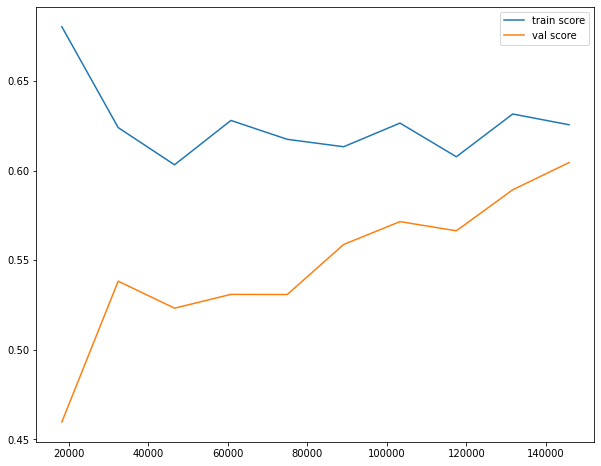

In [10]:
evaluation(model)

Dans les jeux d'entrainement et de test , on a environ 27% des cas de fraudes non detectés. Mauvaise performance !
On remarque que le recall sur le jeu d'entrainement varie très peu au-delà de 40000 échantillons
le recall semble croitre avec le nombre d'échantillons (il y a en effet plus d'échantillons de la classe minoritaire quand la taille de l'échantillon augmente).

# Synthetic Minority Oversampling Technique (SMOTE)

## Nouveau Modèle

In [18]:
# on ne peut utiliser SMOTE dans une pipeline car il n'implemente pas les methodes fit et transform
model = Pipeline([
       ('selector', RFECV(LogisticRegression(), step=5, min_features_to_select=10, cv=5, scoring='recall')),
      ('clf', LogisticRegression()) ])

### Oversampling and Cross-validation

In [ ]:
#https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
#https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier())
]
scores = {name:[] for name, model in models}

kf = KFold(n_splits=5,random_state=0,shuffle=True)

for train_index, test_index in kf.split(X):
        
    # recuperation des indices des Folds
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    # sur-echantillonage avec SMOTE
    sm = SMOTE(random_state=0)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

    # on utilise le rappel comme  metrique
    for name, model in models:
        # entrainement et evaluation du modèle
        model.fit(X_train_sm,y_train_sm)
        y_pred = model.predict(X_test)
        # sauvegarde des scores
        recall = recall_score(y_test,y_pred)
        scores[name].append(recall)

print(scores)

{'Baseline': [], 'CART': [], 'LR': [], 'KNN': [], 'Random forest': []}
0.0
0.9992273274514384


/home/kallen/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.968571993315484


Notre jeu de données est très déséquilibré: les cas de fraudes représentent moins de 1% ! L'algoirthme SMOTE est très utilisé pour générer des données synthétiques. Il sur-échantillonage la classe minoritaire et sous sous-échantillonne la classe majoritaire.

Lorsque que l'on effectue un sur-échantillonnage (sur la classe minoritaire) pour rééquilibrer les données, il est préférable de le faire pendant la cross-validation. De cette façon, on est assuré que le jeu d'entrainement et de test ne se chevauchent pas. 

Dans ce projet, le rappel(recall) est une métrique interessante. En effet, on souhaite detecter le maximum de fraudes possibles. Ce n'est pas bien grave si un cas de non-fraude est classé comme cas de fraude. La banque pourra toujours s'excuser en disant qu'il s'agit d'une fausse alerte. Un estimateur avec un grand rappel (et donc une faible precision) est donc acceptable.




In [36]:
for score, booleans in zip(scores, boolean_features):
    columns = df.columns[[col.startswith('V') for col in df.columns]]
    print('recall moyen: ' + str('%.3f' % score),'Attributs supprimés: ' + ' --> '.join(columns[[not t for t in columns]]))
    

recall moyen: 0.958 Attributs supprimés: 
recall moyen: 0.921 Attributs supprimés: 
recall moyen: 0.951 Attributs supprimés: 
recall moyen: 0.918 Attributs supprimés: 
recall moyen: 0.957 Attributs supprimés: 


Le modèle n'est pas en sur-apprentissage. La précision et le rappel avoisinent 100%. On a amélioré les performances du modèle de façon considérable en utilisant SMOTE